In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.io_utils as io_utils
import utils.visualization_utils as visualization_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
import matplotlib

matplotlib.rcParams['figure.dpi'] = 150


### Setup, grabbing Fixations from S3
- Fixations include fixation start, fixation end. 
- There may be multiple consecutive fixations for one card, treating those as separate
- Will filter out: 
  - trials that did not result in correct/incorrect feedback
  - fixations on the selected item


In [2]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

fs = s3fs.S3FileSystem()

behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]
trial_numbers = np.unique(valid_beh.TrialNumber)
spike_data = spike_general.get_spike_times_by_trial(fs, subject, session, trial=trial_numbers, start_field="TrialStart", end_field="TrialEnd")    

In [3]:
raw_fixation_times = io_utils.get_raw_fixation_times(fs, subject, session)
fixation_features = behavioral_utils.get_fixation_features(behavior_data, raw_fixation_times)

not_chosens = fixation_features.loc[~(fixation_features["ItemChosen"] == fixation_features["ItemNumber"])]
valids = not_chosens[not_chosens["TrialNumber"].isin(trial_numbers)]

End up with 3019 fixations

### Plot Distribution of Fixation Durations

Text(0.5, 0, 'Time Bins (ms)')

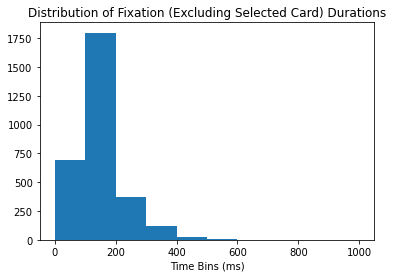

In [5]:
bins = np.arange(0, 1100, 100)
valid_durations = valids["FixationEnd"] - valids["FixationStart"]
plt.hist(valid_durations, bins=bins)
plt.title("Distribution of Fixation (Excluding Selected Card) Durations")
plt.xlabel("Time Bins (ms)")

### Load Firing Rates, Prep Data for Decoding

In [6]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_300_fixation_500.pickle"))
features = valids[["FixationNum", "Color", "Shape", "Pattern"]]

# use a support vector machine model
clf = svm.SVC(decision_function_shape='ovo')

# Look at Spike Counts instead of Firing Rate
mode = "SpikeCounts"

### Loop through Features, decode by 100 ms time windows

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001


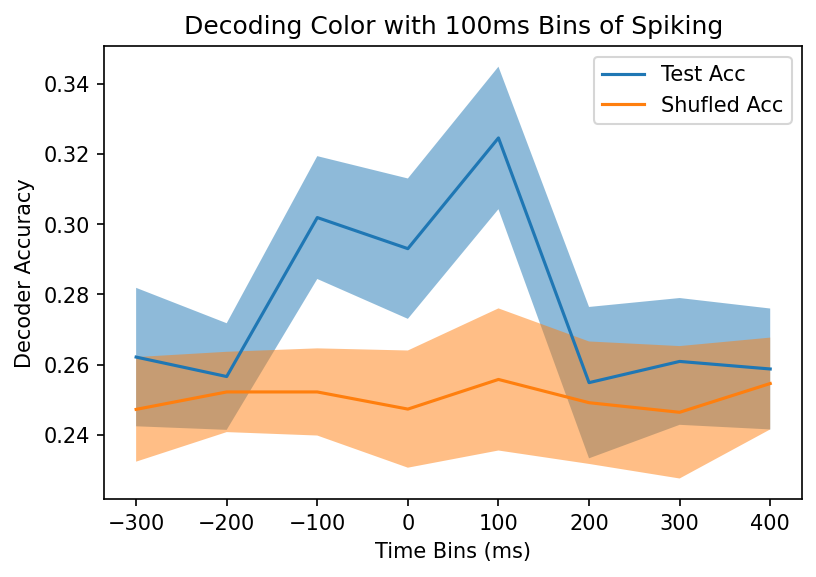

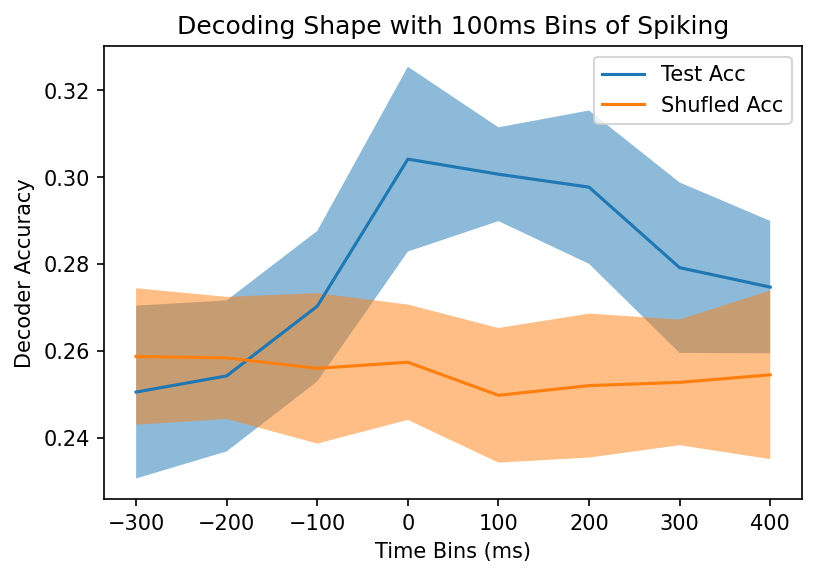

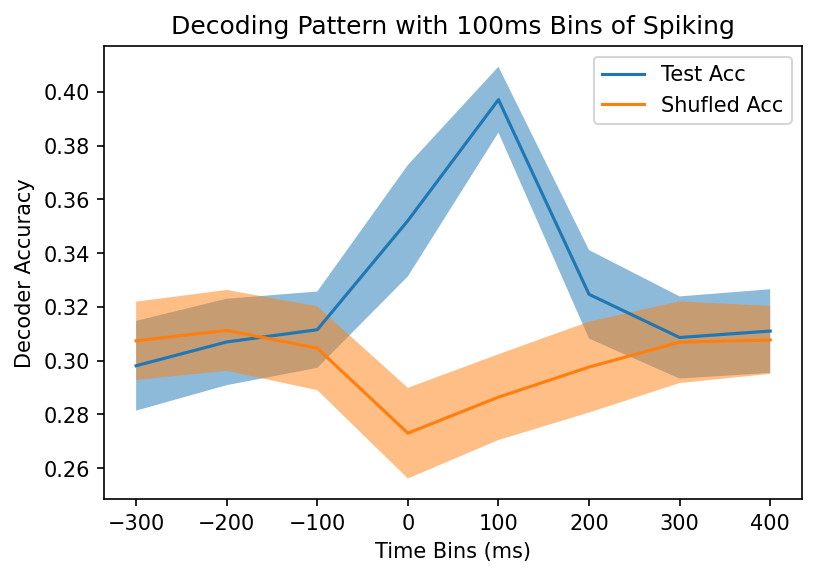

In [9]:
feature_dims = ["Color", "Shape", "Pattern"]
pre_interval = 300
post_interval = 500

for feature_dim in feature_dims:
    # prep data for classification
    # Hack: rename things as trial number to make downstream code work
    inputs = firing_rates.rename(columns={mode: "Value", "IntervalID": "TrialNumber"})
    labels = features.rename(columns={feature_dim: "Feature", "FixationNum": "TrialNumber"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    test_accs_by_bin, shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
        clf, inputs, labels, np.arange(0, 0.8, 0.1), random_splitter
    )
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_accs_{pre_interval}_fixationstart_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_shuffled_accs_{pre_interval}_fixationstart_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        "Test Acc"
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        "Shufled Acc"
    )
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

### Now look at decodability aligned on fixation end

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001


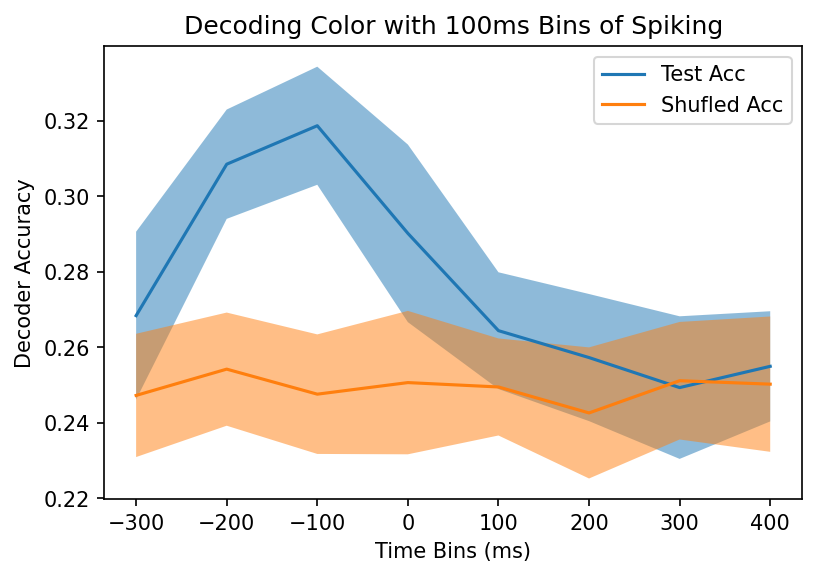

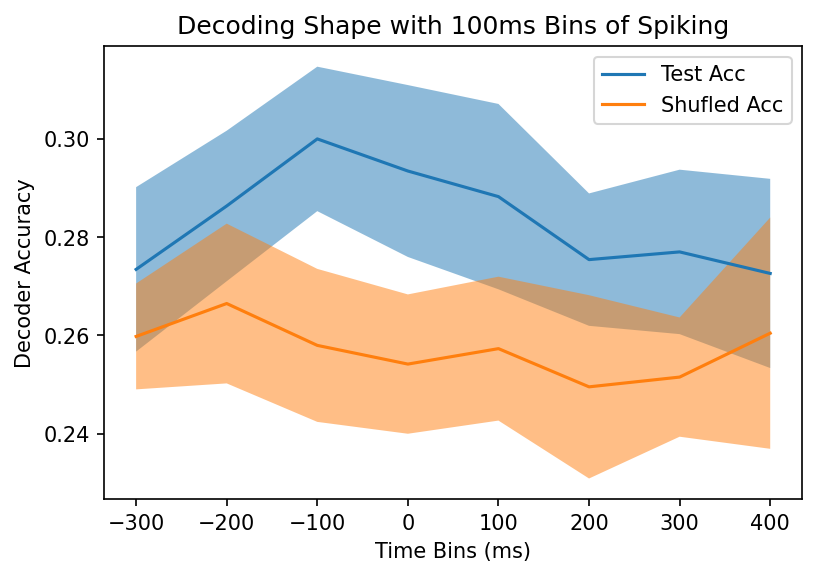

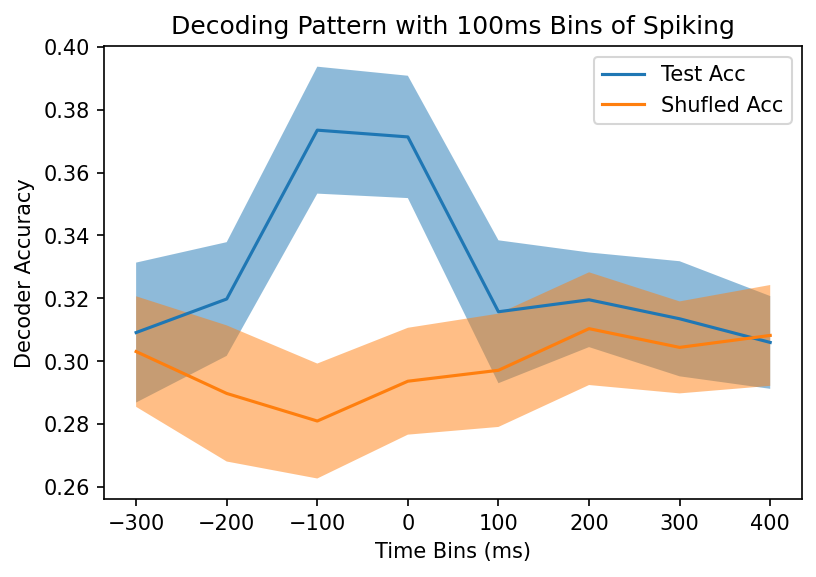

In [11]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_300_fixationend_500.pickle"))

feature_dims = ["Color", "Shape", "Pattern"]
pre_interval = 300
post_interval = 500

for feature_dim in feature_dims:
    # prep data for classification
    # Hack: rename things as trial number to make downstream code work
    inputs = firing_rates.rename(columns={mode: "Value", "IntervalID": "TrialNumber"})
    labels = features.rename(columns={feature_dim: "Feature", "FixationNum": "TrialNumber"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    test_accs_by_bin, shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
        clf, inputs, labels, np.arange(0, 0.8, 0.1), random_splitter
    )
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_accs_{pre_interval}_fixationend_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_shuffled_accs_{pre_interval}_fixationend_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        "Test Acc"
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        "Shufled Acc"
    )
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

### Include Selected Cards back into analysis, just look at first fixations per item, don't included "selected" fixation

In [4]:
first_fixations = behavioral_utils.get_first_fixations_for_cards(fixation_features)
no_selected_fixations = behavioral_utils.remove_selected_fixation(first_fixations)
valids = no_selected_fixations[no_selected_fixations["TrialNumber"].isin(trial_numbers)]

In [5]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_300_filtered_fixationstart_500.pickle"))
features = valids[["FixationNum", "Color", "Shape", "Pattern"]]

# use a support vector machine model
clf = svm.SVC(decision_function_shape='ovo')

# Look at Spike Counts instead of Firing Rate
mode = "SpikeCounts"

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001


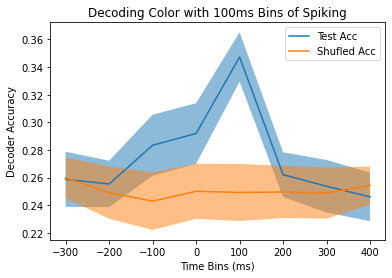

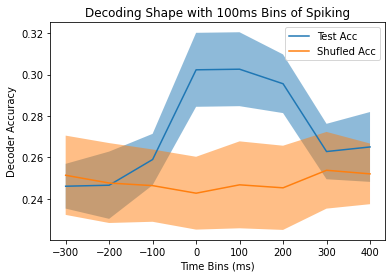

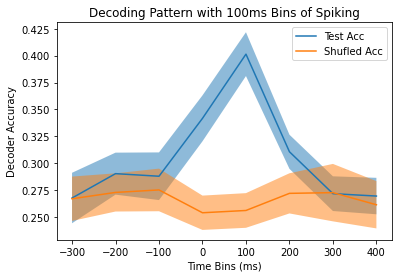

In [6]:
feature_dims = ["Color", "Shape", "Pattern"]
pre_interval = 300
post_interval = 500

for feature_dim in feature_dims:
    # prep data for classification
    # Hack: rename things as trial number to make downstream code work
    inputs = firing_rates.rename(columns={mode: "Value", "IntervalID": "TrialNumber"})
    labels = features.rename(columns={feature_dim: "Feature", "FixationNum": "TrialNumber"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    test_accs_by_bin, shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
        clf, inputs, labels, np.arange(0, 0.8, 0.1), random_splitter
    )
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_accs_{pre_interval}_filtered_fixationstart_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_shuffled_accs_{pre_interval}_filtered_fixationstart_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        "Test Acc"
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        "Shufled Acc"
    )
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001


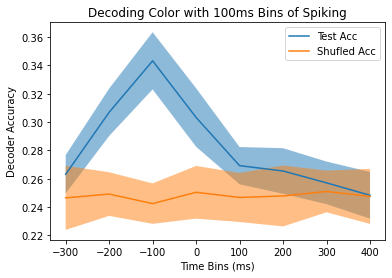

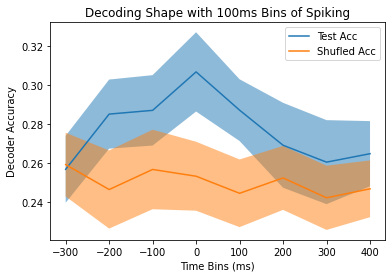

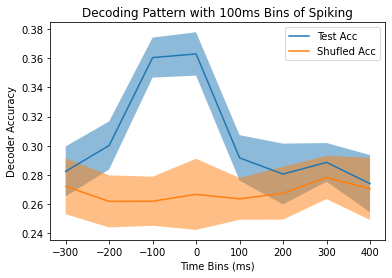

In [7]:
feature_dims = ["Color", "Shape", "Pattern"]
pre_interval = 300
post_interval = 500
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_300_filtered_fixationend_500.pickle"))


for feature_dim in feature_dims:
    # prep data for classification
    # Hack: rename things as trial number to make downstream code work
    inputs = firing_rates.rename(columns={mode: "Value", "IntervalID": "TrialNumber"})
    labels = features.rename(columns={feature_dim: "Feature", "FixationNum": "TrialNumber"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    test_accs_by_bin, shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
        clf, inputs, labels, np.arange(0, 0.8, 0.1), random_splitter
    )
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_accs_{pre_interval}_filtered_fixationend_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_shuffled_accs_{pre_interval}_filtered_fixationend_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        "Test Acc"
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        "Shufled Acc"
    )
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()